# Lab 3. Activity detection. Iurii Fedotov
## 1. Reading the data, loading workout plan and creating useful functions

In [137]:
import pandas as pd
import numpy as np
import datetime
import math

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from scipy.fftpack import fft, fftfreq

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from scipy import signal

from IPython.display import display

In [138]:
# Import the activity file generated on iPhone
iphone_activity_df = pd.read_csv(
    './yury_dataset.csv',
    names=['time', 'accX', 'accY', 'accZ', 'accABS'],
    skiprows=[0]
)

# Save the last second of recording into a variable – we will use it later a few times
last_second = math.ceil(iphone_activity_df.iloc[-1].time)

# Initialize a list of dicts to store my workout plan – it will be used to label the data
workout_plan = [
    {
        "start_second": 0,
        "finish_second": 30,
        "name": "running"
    },
    {
        "start_second": 30,
        "finish_second": 60,
        "name": "jumping"
    },
    {
        "start_second": 60,
        "finish_second": 90,
        "name": "walking"
    },
    {
        "start_second": 90,
        "finish_second": 120,
        "name": "upstairs"
    },
    {
        "start_second": 120,
        "finish_second": 150,
        "name": "downstairs"
    },
    {
        "start_second": 150,
        "finish_second": 180,
        "name": "running"
    },
    {
        "start_second": 180,
        "finish_second": 210,
        "name": "jumping"
    },
    {
        "start_second": 210,
        "finish_second": 240,
        "name": "rest"
    },
    {
        "start_second": 240,
        "finish_second": 270,
        "name": "walking"
    },
    {
        "start_second": 270,
        "finish_second": 300,
        "name": "upstairs"
    },
    {
        "start_second": 300,
        "finish_second": 330,
        "name": "downstairs"
    },
    {
        "start_second": 330,
        "finish_second": last_second,
        "name": "rest"
    },
]

# This dict will be used to create consistent color coding in charts
colors_mapping = {
    "running": "red",
    "jumping": "orange",
    "walking": "green",
    "upstairs": "blue",
    "downstairs": "yellow",
    "rest": "grey"
}

def get_seconds_of_activity_changes(workout_plan):
    """Given a workout plan, returns a list of seconds when activity was changed, sorted in ascending order.
    
    Args:
      workout_plan: list of dictionaries with 3 keys: start_second, finish_second and name.
      
    Returns:
      A list of seconds when activity was changed, sorted in ascending order.
    """
    
    seconds = []
    
    # Collect all timestamps stored in workout plan
    for activity in workout_plan:
        seconds.extend([activity["start_second"], activity["finish_second"]])
    
    # Remove first and last timestamps, since we don't consider them a change, and remove duplicates
    activity_changes_seconds = list(set(seconds[1:-1]))
    
    return activity_changes_seconds

def moment_belongs_to_activity(moment, activity):
    """Checks if a given moment, expressed as floating second, belongs to a particular activity in workout plan.
    
    Args:
      moment: floating second, e.g. 4.1212.
      activity: dictionary with 3 keys: start_second, finish_second and name.
      
    Returns:
      True, if a moment belongs to a particular activity in workout plan, False otherwise
    """
    
    if (moment >= activity["start_second"]) and (moment < activity["finish_second"]):
        return True
    else:
        return False

def label_moment_to_activity(moment):
    """Given a moment as floating second, it returns a corresponding activity name.
    
    Args:
      moment: floating second, e.g. 4.1212.
      
    Returns:
      Name of the corresponding activity as a string
    """
    
    for activity in workout_plan:
        if moment_belongs_to_activity(moment, activity):
            return activity["name"]
        
def get_power_peaks(series):
    """Returns power peaks for series of acceleration values
    
    Args:
      series: pandas series with absolute acceleration values
      
    Returns:
      sorted_idxs: indices of values with peaks,
      peak_freqs: frequencies at peaks, sorted accordingly,
      peak_psd: power spectral density at peaks, sorted accordingly
    """
    
    # A power peak occurs after two changes in the line
    freqs, psd = signal.welch(series, fs=200, scaling='spectrum')
    current_diff = 0
    prev_diff = 0
    peak_freqs = []
    peak_psd = []
    for i in range(0, freqs.size):
        if i == 1:
            current_diff = psd[i] - psd[i - 1]
            
        if i > 1:
            prev_diff = current_diff
            current_diff = psd[i] - psd[i - 1]
        
        if np.sign(prev_diff) != np.sign(current_diff) and np.sign(prev_diff) == 1 and i > 0:
            peak_freqs.append(freqs[i - 1])
            peak_psd.append(psd[i - 1])
        
    sorted_idxs = (-np.array(peak_psd)).argsort()
    
    return sorted_idxs, peak_freqs, peak_psd

## 2. Labelling the raw data and exploring it

In [139]:
iphone_activity_df["activity"] = iphone_activity_df.time.apply(label_moment_to_activity)
display(iphone_activity_df)

,time,accX,accY,accZ,accABS,activity
0,0.000000,-1.504222,4.951853,8.915011,10.308295,running
1,0.010040,-1.151855,4.767735,8.928932,10.187438,running
2,0.020111,-1.146017,4.449797,9.121432,10.213450,running
3,0.030182,-1.073268,4.301605,8.784333,9.839726,running
4,0.040222,-0.587678,4.306694,8.540789,9.583218,running
...,...,...,...,...,...,...
36047,362.701344,-3.638484,5.368736,7.493866,9.910596,rest
36048,362.711384,-3.675906,5.292095,7.469617,9.864772,rest
36049,362.721455,-3.645220,5.390441,7.464078,9.902371,rest
36050,362.731525,-3.746260,5.448520,7.299870,9.849311,rest


## 3. Moving from raw labelled data to extended labelled data
This is the core of our program. We will divide our dataset in windows of 3 seconds and and overlapping of 50%.

In [140]:
window_size = 3
overlapping = 0.5  # % of the last window that overlaps the current window

# The list of features we are going to generate
allFeatures = ['start', 'end', 'max', 'min', 'avg', 'std', 'f0', 'p0', 'f1', 'p1', 'f2', 'p2', 'activity']

# New dataframe with the features
extended_activity_df = pd.DataFrame(columns=allFeatures)

# Start and end are the moment in seconds of starting and ending of each window
start = 0
end = start + window_size

while end <= iphone_activity_df.iloc[-1].time:
    
    # The window is the signal between start and end times
    window = iphone_activity_df[(iphone_activity_df['time'] >= start) & (iphone_activity_df['time'] < end)]
    
    # Get time domain features
    max = window.accABS.max()
    min = window.accABS.min()
    avg = window.accABS.mean()
    std = window.accABS.std()
    
    # Get frequency domain features
    sorted_idxs, peak_freqs, peak_psd = get_power_peaks(window.accABS)
    
    # Get acitivty type – we assume that interval's activity is the mode of activities within it
    activity = window.activity.value_counts().keys()[0]
    
    # Write the features in the feature dataset
    row = pd.DataFrame([[\
        start,\
        end,\
        max,\
        min,\
        avg,\
        std,\
        peak_freqs[sorted_idxs[0]],\
        peak_psd[sorted_idxs[0]],\
        peak_freqs[sorted_idxs[1]],\
        peak_psd[sorted_idxs[1]],\
        peak_freqs[sorted_idxs[2]],\
        peak_psd[sorted_idxs[2]],\
        activity,\
    ]], columns=allFeatures)
    extended_activity_df = extended_activity_df.append(row)
    
    # Calculate the next window in the loop
    start = start + (end - start) * (1 - overlapping)
    end = start + window_size

# Explore the resulting extended dataset
extended_activity_df.sample(10)

,start,end,max,min,avg,std,f0,p0,f1,p1,f2,p2,activity
0,267,270,30.851002,3.248151,10.211972,2.456930,10.15625,0.161625,0.78125,0.089923,11.71875,0.087290,walking
0,52.5,55.5,61.295544,0.786415,13.166880,12.808206,3.12500,77.163543,12.50000,23.401424,9.37500,20.039633,jumping
0,192,195,72.227150,0.950339,13.720706,11.888943,3.12500,72.988975,9.37500,23.854909,12.50000,12.724183,jumping
0,268.5,271.5,27.812305,2.010304,10.217224,2.301916,4.68750,0.081786,0.78125,0.074340,12.50000,0.074060,walking
0,189,192,79.519606,0.610538,13.325686,12.930429,3.12500,66.346997,12.50000,22.502076,9.37500,18.670684,jumping
0,139.5,142.5,23.140165,2.536269,10.176103,3.919856,3.90625,6.300623,10.15625,1.215983,21.87500,0.308209,downstairs
0,339,342,9.846516,9.633173,9.730140,0.034860,10.93750,0.000282,14.06250,0.000082,18.75000,0.000044,rest
0,19.5,22.5,41.937085,1.757732,16.323679,9.405024,4.68750,27.086471,7.03125,10.447159,11.71875,6.684839,running
0,252,255,24.998283,3.826341,11.032177,4.062112,3.12500,4.746914,4.68750,2.043200,6.25000,1.706797,walking
0,63,66,24.201214,4.166169,10.661676,3.997030,3.12500,3.863366,12.50000,1.648633,5.46875,1.287735,walking


## 4. Testing 2 ML algorithms: KNN classifier and Decision Tree Classifier

In [141]:
y = extended_activity_df.activity
X = extended_activity_df.drop(['start','end', 'activity'], axis=1)

from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, ShuffleSplit, GridSearchCV

# Create a shuffle split of data for further cross validation
split = ShuffleSplit(n_splits=5, test_size=0.4, random_state=1950)

def calculate_cv_accuracy(model):
    """Calculates cross-validated accuracy for a model.
    
    Args:
      model: model object.
      
    Returns:
      Average accuracy among the cross validation folds
    """
    
    cv_accuracies = cross_val_score(model, X, y, cv = split, scoring = 'accuracy')
    avg_accuracy = np.mean(cv_accuracies)
    return avg_accuracy

"""Algorithm 1: KNN Classifier"""

knn_foropt = KNeighborsClassifier()
parameters_knn = {
    "n_neighbors": [1,2,3,4,5,7,10,20]
}

# Select the best hyperparameter value, based on accuracy
searcher_knn = GridSearchCV(knn_foropt, parameters_knn, cv = split, scoring = 'accuracy')
searcher_knn.fit(X, y)
print("Best GridSearch params KNN:", searcher_knn.best_params_)

# Create an object for the final model.
knn = KNeighborsClassifier(n_neighbors = searcher_knn.best_params_['n_neighbors'])

# Validate the model. 5 fold CV, metric - accuracy.
knn_accuracy = calculate_cv_accuracy(knn)
print('Average CV accuracy for KNN: ', str(round(knn_accuracy,2)))

"""Algorithm 2: Decision Tree Classifier"""

dt_foropt = DecisionTreeClassifier()
parameters_dt = {
    'criterion':['gini', 'entropy'],
    'max_depth': np.arange(3,20,1)
}

# Select the best hyperparameter value, based on accuracy
searcher_dt = GridSearchCV(dt_foropt, parameters_dt, cv = split, scoring = 'accuracy')
searcher_dt.fit(X, y)
print("Best GridSearch params Decision Tree:", searcher_dt.best_params_)

# Create an object for the final model.
dt = DecisionTreeClassifier(criterion = searcher_dt.best_params_['criterion'],
                            max_depth = searcher_dt.best_params_['max_depth'],)

# Validate the model. 5 fold CV, metric - accuracy.
dt_accuracy = calculate_cv_accuracy(dt)
print('Average CV accuracy for Decision Tree: ', str(round(dt_accuracy,2)))

Best GridSearch params KNN: {'n_neighbors': 3}
Average CV accuracy for KNN:  0.83
Best GridSearch params Decision Tree: {'criterion': 'entropy', 'max_depth': 19}
Average CV accuracy for Decision Tree:  0.82


**The highest cross-validated accuracy was demonstrated by KNN classifier, therefore, I decided to use it in my final solution.**

In [142]:
knn.fit(X, y)
score = knn.score(X, y)
print('KNN accuracy, trained & tested on all data: ', str(round(score,2)))
predictions = knn.predict(X)

KNN accuracy, trained & tested on all data:  0.91


## 5. Exploring results

In [143]:
# Prepare a dataframe with all info we need to explore results
results_dict = {
    "start": extended_activity_df.start,
    "end": extended_activity_df.end,
    "actual": y,
    "predicted": predictions
}

results_df = pd.DataFrame(results_dict)
results_df["match"] = results_df["actual"] == results_df["predicted"]

display(results_df)

,start,end,actual,predicted,match
0,0,3,running,running,True
0,1.5,4.5,running,running,True
0,3,6,running,running,True
0,4.5,7.5,running,running,True
0,6,9,running,running,True
...,...,...,...,...,...
0,352.5,355.5,rest,rest,True
0,354,357,rest,rest,True
0,355.5,358.5,rest,rest,True
0,357,360,rest,rest,True


In [144]:
# Calculate percentage of correctly classified intervals per activity type
match_rate = results_df.groupby('actual').match.mean().sort_values(ascending=True)

# Create a list of colors which will be used in one of the charts
colors_for_barh = [colors_mapping[activity] for activity in match_rate.index.tolist()]

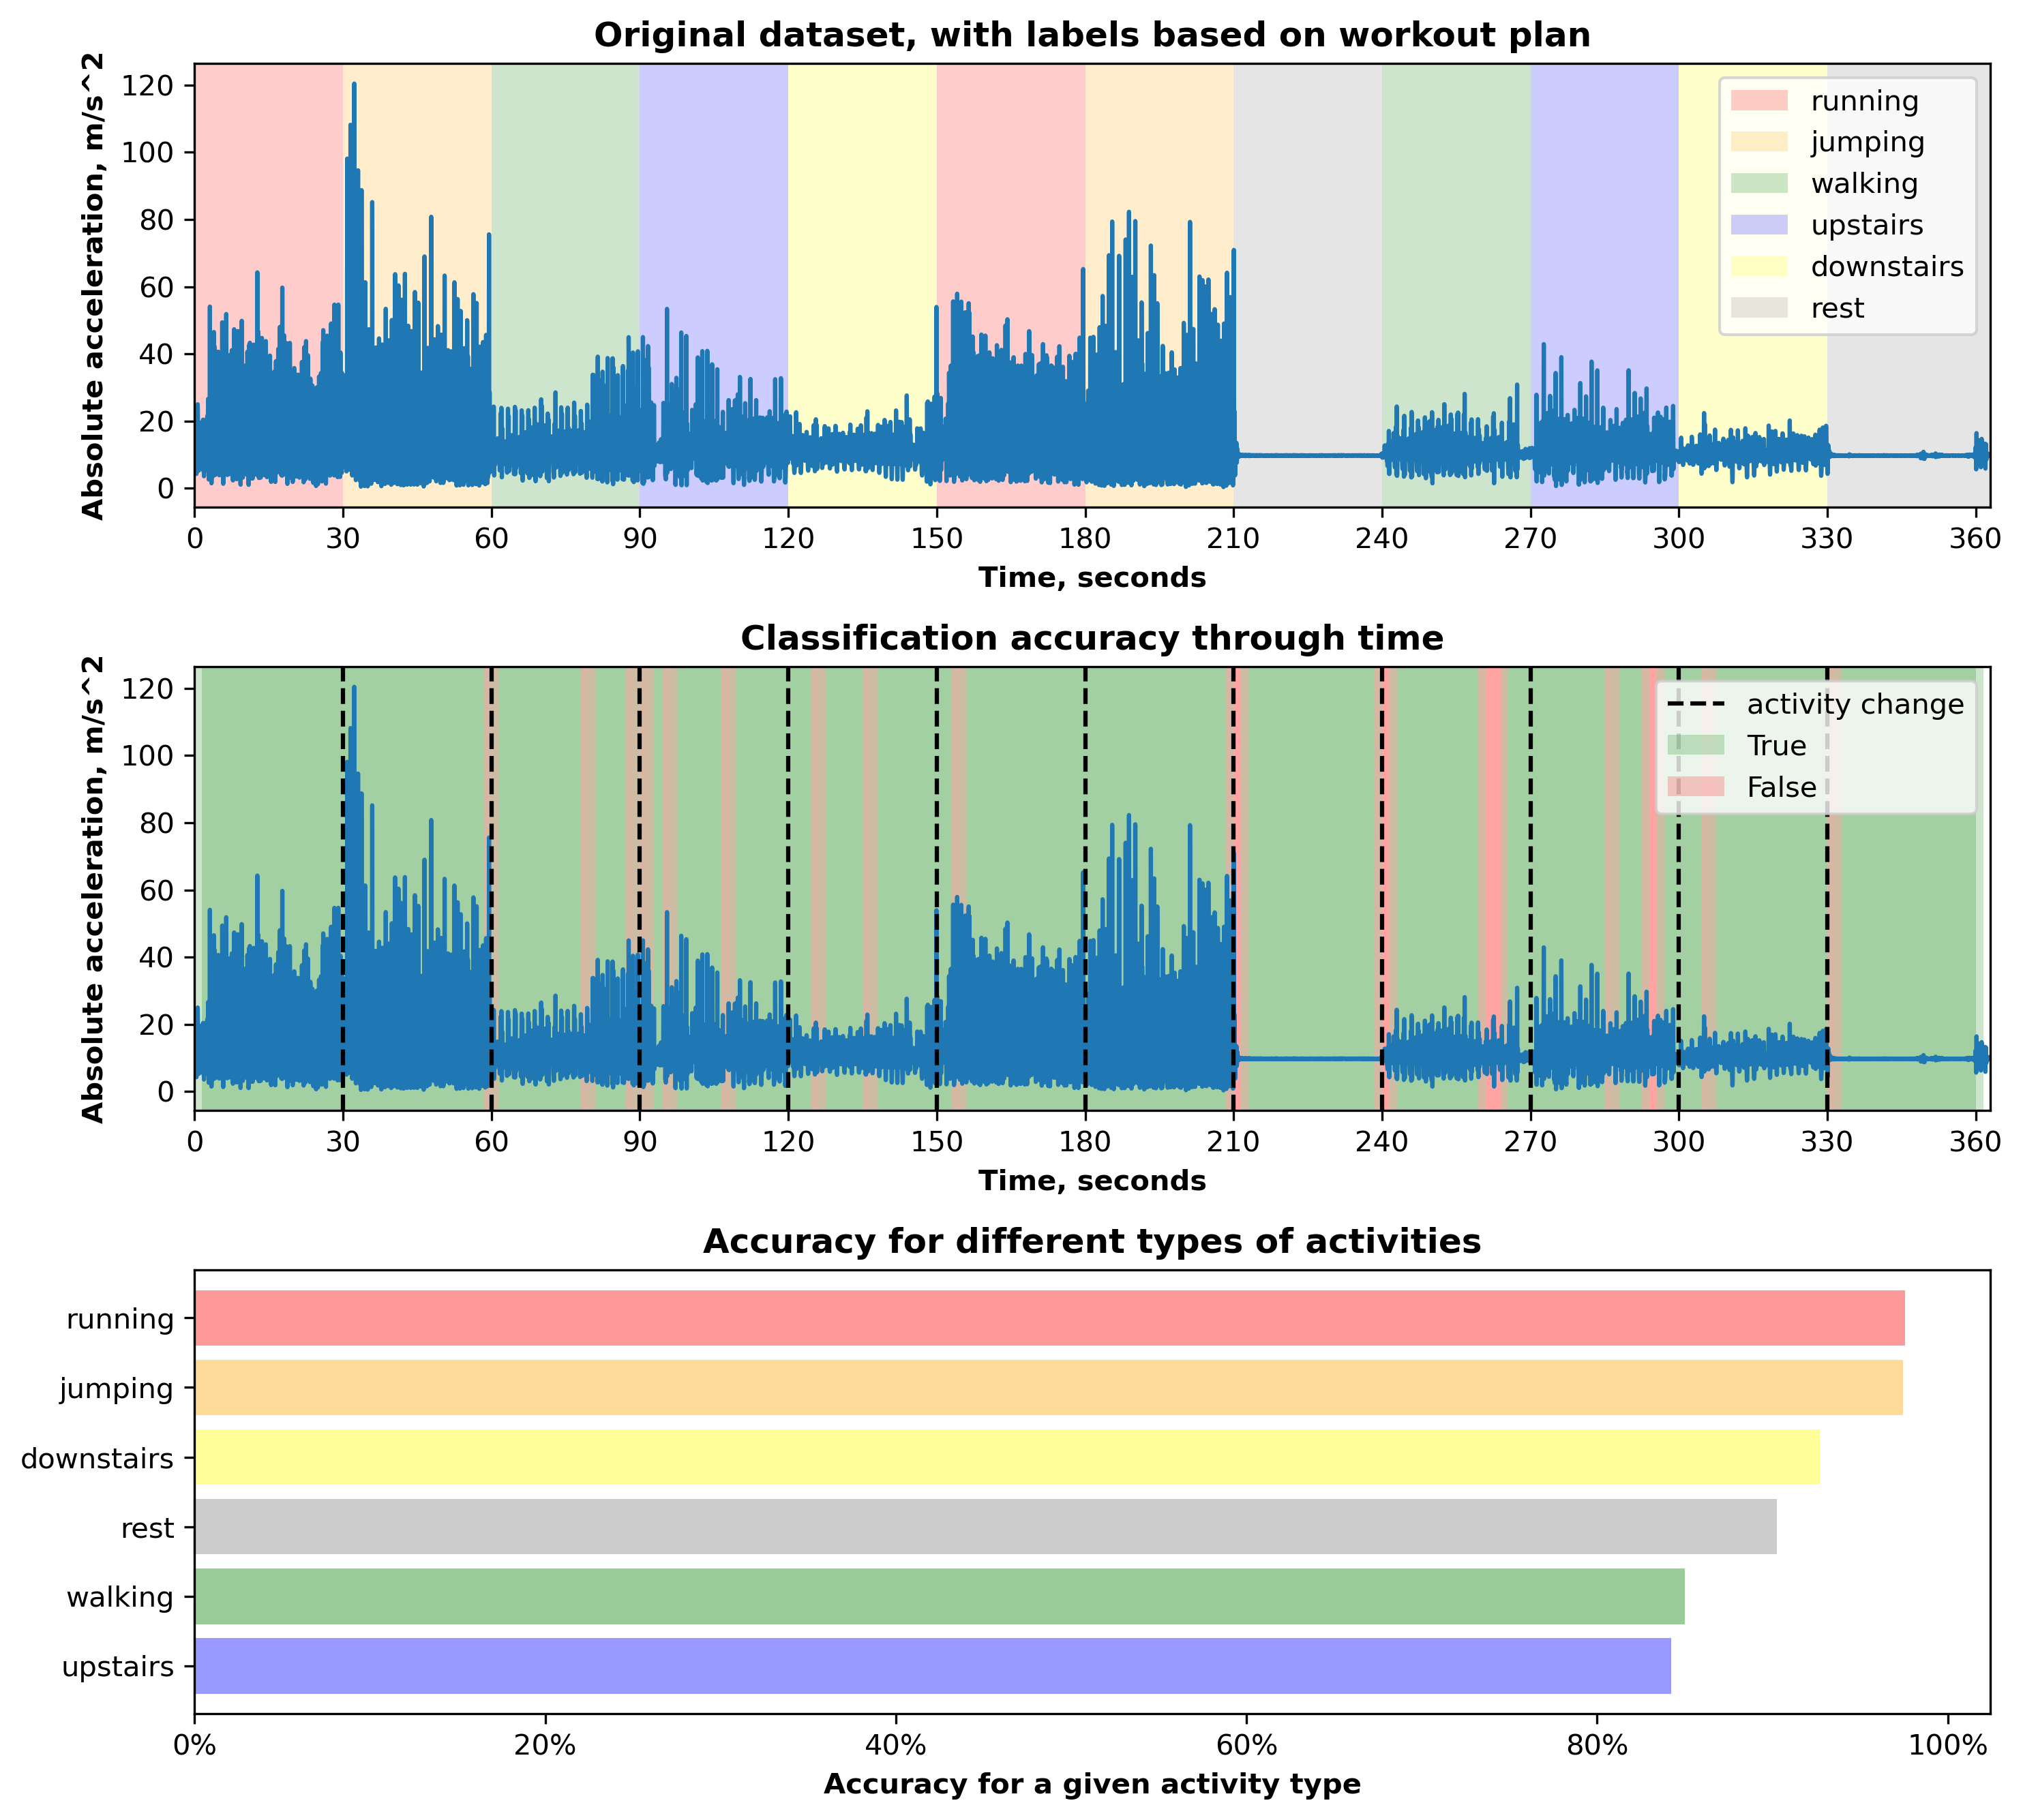

In [145]:
fig = plt.figure(figsize = (10,9), dpi=300)

"""First axes – original dataset"""
ax1 = fig.add_subplot(311)

ax1.plot(iphone_activity_df['time'], iphone_activity_df['accABS'])

added_labels = []

for activity in workout_plan:
    
    # This loop is a bit tricky – it prevents duplicate labels in legend
    if activity["name"] not in added_labels:
        added_labels.append(activity["name"])
        add_label = True
    else:
        add_label = False
    
    ax1.axvspan(
        activity["start_second"],
        activity["finish_second"],
        facecolor = colors_mapping[activity["name"]],
        alpha = 0.2,
        label = activity["name"] if add_label else None
    )
    
ax1.set_xlim(0, last_second)
ax1.xaxis.set_ticks(np.arange(0, last_second, 30))
    
ax1.set_xlabel('Time, seconds', weight = 'bold')
ax1.set_ylabel('Absolute acceleration, m/s^2', weight = 'bold')
ax1.set_title('Original dataset, with labels based on workout plan', weight = 'bold')

ax1.legend()

"""Second axes – classification accuracy through time"""
ax2 = fig.add_subplot(312)

ax2.plot(iphone_activity_df['time'], iphone_activity_df['accABS'])

# This dictionary is a bit tricky – it prevents duplicate labels in legend
present_in_legend = {
    True: False,
    False: False
}

for index, row in results_df.iterrows():
    
    ax2.axvspan(
        row.start,
        row.end,
        facecolor = "green" if row.match else "red",
        alpha = 0.2,
        label = row.match if not present_in_legend[row.match] else None
    )
    
    if row.match == True:
        present_in_legend[True] = True
        
    if row.match == False:
        present_in_legend[False] = True

change_moments = get_seconds_of_activity_changes(workout_plan)

for second in change_moments:
    ax2.axvline(
        second,
        color = "black",
        linestyle = "dashed",
        label = "activity change" if second == change_moments[0] else None # Added only once, in the first loop
    )

ax2.set_xlim(0, last_second)
ax2.xaxis.set_ticks(np.arange(0, last_second, 30))
    
ax2.set_xlabel('Time, seconds', weight = 'bold')
ax2.set_ylabel('Absolute acceleration, m/s^2', weight = 'bold')
ax2.set_title('Classification accuracy through time', weight = 'bold')

ax2.legend()

"""Third axes – Accuracy for different types of activities"""
ax3 = fig.add_subplot(313)

ax3.barh(
    match_rate.index.tolist(),
    match_rate.values.tolist(),
    color = colors_for_barh,
    alpha = 0.4
)

ax3.set_xlabel('Accuracy for a given activity type', weight = 'bold')
ax3.set_title('Accuracy for different types of activities', weight = 'bold')
ax3.xaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.tight_layout()
plt.show()

## 6. Conclusions
- I tested 2 algorithms to predict activity type, and their cross-validated accuracy ranged from 0.81 to 0.83.
- The highest cross-validated accuracy was demonstrated by KNN Classifier - 83%. 
- **KNN's accuracy, estimated while trained and tested on the entire dataset, was 91%, which seems very good.**
- From the charts we see that most errors in classification occur at the intervals where activity is changed. It was expected, because there invervals by definition create dirtier signals.
- Among the activites I used in my workout, the model demonstrated highest accuracy at recognizing running, and the hardest activity to recoginze was walking upstairs.